# Maximum-likelihood MSMs

For those already familiar with the interface: The corresponding [API docs](../api/generated/deeptime.markov.msm.MaximumLikelihoodMSM.rst#deeptime.markov.msm.MaximumLikelihoodMSM).

This kind of estimator tries to determine the most likely transition matrix $P\in\mathbb{R}^{n\times n}$ given the [transition counts](./transition-counting.ipynb) $C\in\mathbb{R}^{n\times n}$ <cite data-footcite="schutte1999direct">(Schuette, 1999)</cite><cite data-footcite="wu2020variational">(Wu, 2020)</cite>.

The likelihood that a transition matrix $P$ belongs to a trajectory $S = (s_0,\ldots,s_T)$ is given by

$$ \mathcal{L}(P) = \mathbb{P}(P\mid S) = \prod_{i,j=1}^n P_{ij}^{C_{ij}}. $$

After importing the package, the estimator can be instantiated:

In [1]:
import deeptime.markov as markov

estimator = markov.msm.MaximumLikelihoodMSM(
    reversible=True,
    stationary_distribution_constraint=None
)

It has two main parameters:

- `reversible` determines whether the estimated MSM should have a detailed balance symmetry, i.e.,
  $$ \pi_i P_{ij} = \pi_j P_{ji}\quad\forall i,j=1,\ldots,n, $$
  where $\pi$ is the stationary probability distribution vector. It is the probability vector which does not change under $P$, i.e., $P\pi = \pi$ and therefore is eigenvector for eigenvalue $\lambda_0$ = 1. A sufficient condition for existence and uniqueness of $\pi$ is the irreducibility of the markov chain, i.e., the count matrix must be connected.
- `stationary_distribution_constraint`: In case the stationary distribution $\pi$ is known a priori, the search space can be restricted to stochastic matrices which have $\pi$ as stationary distribution.

To demonstrate the estimator, we can generate a sequence of observations from a markov state model. It has three states and a probability of $97\%$ to stay in its current state. The remaining $3\%$ are used as jump probabilities.

In [2]:
import numpy as np

p11 = 0.97
p22 = 0.97
p33 = 0.97
P = np.array([[p11, 1 - p11, 0], [.5*(1 - p22), p22, 0.5*(1-p22)], [0, 1-p33, p33]])
true_msm = markov.msm.MarkovStateModel(P)

A realization of this markov state model can be generated:

In [3]:
trajectory = true_msm.simulate(50000)

And we can gather statistics about it

In [4]:
counts_estimator = markov.TransitionCountEstimator(
    lagtime=1, count_mode="sliding"
)
counts = counts_estimator.fit(trajectory).fetch_model()

as well as re-estimate an MSM.

In [5]:
msm = estimator.fit(counts).fetch_model()

The estimated transition matrix is reasonably close to the ground truth:

In [6]:
print("Estimated transition matrix:", msm.transition_matrix)
print("Estimated stationary distribution:", msm.stationary_distribution)

Estimated transition matrix: [[0.97174192 0.02825808 0.        ]
 [0.01436794 0.97057023 0.01506183]
 [0.         0.02829029 0.97170971]]
Estimated stationary distribution: [0.24913759 0.48999019 0.26087221]


Now since we know the stationary distribution of the ground truth, we can restrict the estimator's optimization space to it:

In [7]:
print("True stationary vector:", true_msm.stationary_distribution)

True stationary vector: [0.25 0.5  0.25]


In [8]:
estimator.stationary_distribution_constraint = true_msm.stationary_distribution

msm_statdist = estimator.fit(counts).fetch_model()

In [9]:
print("Estimated transition matrix:", msm_statdist.transition_matrix)
print("Estimated stationary distribution:", msm_statdist.stationary_distribution)

Estimated transition matrix: [[0.97150033 0.02849967 0.        ]
 [0.01424983 0.97116296 0.0145872 ]
 [0.         0.0291744  0.9708256 ]]
Estimated stationary distribution: [0.25 0.5  0.25]


With the markov state model object one also has access to relaxation timescales $t_s = -\tau / \mathrm{ln} | \lambda_i |, i = 2,...,k+1$:

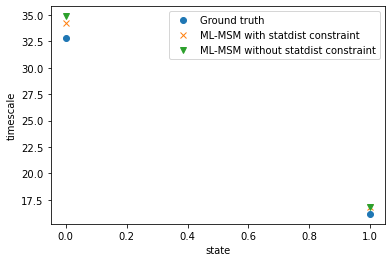

In [10]:
import matplotlib.pyplot as plt

plt.plot(true_msm.timescales(), 'o', label="Ground truth")
plt.plot(msm_statdist.timescales(), 'x', label="ML-MSM with statdist constraint")
plt.plot(msm.timescales(), 'v', label="ML-MSM without statdist constraint")
plt.xlabel("state")
plt.ylabel("timescale")
plt.legend();

## Bayesian sampling

While the maximum likelihood estimation is useful, it does not say anything about uncertainties. These can be obtained by estimating a Bayesian posterior with the [Bayesian MSM](../api/generated/deeptime.markov.msm.BayesianMSM.rst#deeptime.markov.msm.BayesianMSM) <cite data-footcite="trendelkamp2015estimation">(Trendelkamp-Schroer, 2015)</cite>. The posterior contains the prior around which sampling was performed as well as samples over which statistics can be collected. 

Similarly to the maximum-likelihood estimator it has the option to make estimation `reversible` as well as to introduce a `stationary_distribution_constraint`. Furthermore, it can be specified how many samples should be drawn as well as how many Gibbs sampling should be performed for each output sample.

In [11]:
estimator = markov.msm.BayesianMSM(
    n_samples=100,
    n_steps=10,
    reversible=True,
    stationary_distribution_constraint=None
)

To fit the model, an effective counting should be used as sliding window counting leads to wrong uncertainties.

In [12]:
counts_estimator = markov.TransitionCountEstimator(
    lagtime=1, count_mode="effective"
)
counts_effective = counts_estimator.fit(trajectory).fetch_model()

With the estimated effective counts, we are ready to estimate the posterior.

In [13]:
bmsm_posterior = estimator.fit(counts_effective).fetch_model()

The prior can be accessed via the `prior` property, the samples can be accessed via the `samples` property. Both are just instances of [MarkovStateModel](../api/generated/deeptime.markov.msm.MarkovStateModel.rst#deeptime.markov.msm.MarkovStateModel) and a list thereof, respectively. 

In [14]:
print("# samples:", len(bmsm_posterior.samples))

# samples: 100


The posterior instance also offers a method to gather statistics over all evaluatable methods of the markov state model. Just put the name of method or property as a string, if it is a method of something that is returned by another method, just separate with a `/`. Below a few examples:

In [15]:
stats_P = bmsm_posterior.gather_stats("transition_matrix")
stats_timescales = bmsm_posterior.gather_stats("timescales")
stats_C = bmsm_posterior.gather_stats("count_model/count_matrix")

If a quantity evaluation requires arguments, they can be attached to the `gather_stats` method:

In [16]:
stats_mfpt = bmsm_posterior.gather_stats("mfpt", A=0, B=1)

These statistics contain mean, standard deviation, as well as confidence intervals.

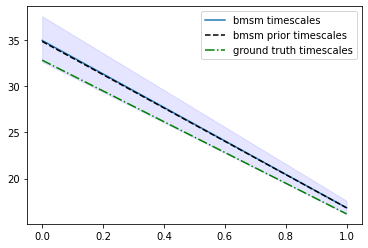

In [17]:
plt.plot([0, 1], stats_timescales.mean, label="bmsm timescales")
plt.fill_between([0, 1], stats_timescales.L, stats_timescales.R, color='b', alpha=.1)
plt.plot([0, 1], bmsm_posterior.prior.timescales(), "k--", label="bmsm prior timescales")
plt.plot([0, 1], true_msm.timescales(), "g-.", label="ground truth timescales")
plt.legend();

To, e.g., visualize samples differently or evaluate other kinds of moments, one can get access to the evaluated quantities directly by setting `store_samples` to `True`:

In [18]:
stats_mfpt = bmsm_posterior.gather_stats("mfpt", store_samples=True, A=0, B=1)
print("# samples:", len(stats_mfpt.samples))

# samples: 100
